In [2]:
import numpy as np
import math
from sys import maxsize
import matplotlib.pyplot as plt

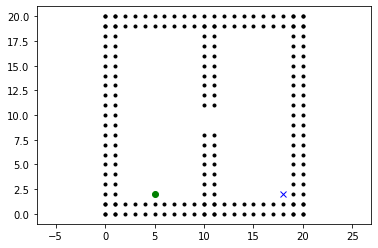

In [20]:
show_animation = False

class State:

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.state = "."
        self.t = "new"  # tag for state
        self.h = 0
        self.k = 0
        self.action = -1

    def cost(self, state):
        if self.state == "#" or state.state == "#":
            return maxsize

        return math.sqrt(math.pow((self.x - state.x), 2) +
                         math.pow((self.y - state.y), 2))

    def set_state(self, state):
        """
        .: new
        #: obstacle
        e: oparent of current state
        *: closed state
        s: current state
        """
        if state not in ["s", ".", "#", "e", "*"]:
            return
        self.state = state


class Map:

    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.map = self.init_map()

    def init_map(self):
        map_list = []
        for i in range(self.row):
            tmp = []
            for j in range(self.col):
                tmp.append(State(i, j))
            map_list.append(tmp)
        return map_list

    def get_neighbors(self, state):
        state_list = []
        for i in [1, 0, -1]:
            for j in [1, 0, -1]:
                if i == 0 and j == 0:
                    continue
                if state.x + i < 0 or state.x + i >= self.row:
                    continue
                if state.y + j < 0 or state.y + j >= self.col:
                    continue
                state_list.append(self.map[state.x + i][state.y + j])

        return state_list

    def set_obstacle(self, point_list):
        for x, y in point_list:
            if x < 0 or x >= self.row or y < 0 or y >= self.col:
                continue

            self.map[x][y].set_state("#")


class Dstar:
    def __init__(self, maps):
        self.map = maps
        self.open_list = set()
        self.action_dict = {(1,0):0, (-1,0):1, (0,1):2, (0,-1):3, (1,1):4, (1,-1):5, (-1,1):6, (-1,-1):7}

    def process_state(self):
        x = self.min_state()

        if x is None:
            return -1

        k_old = self.get_kmin()
        self.remove(x)
        state_list = self.map.get_neighbors(x)
        if k_old < x.h:
            for y in state_list:
                if y.h <= k_old and x.h > y.h + x.cost(y):
                    x.parent = y
                    x.h = y.h + x.cost(y)
        elif k_old == x.h:
            for y in state_list:
                if y.t == "new" or y.parent == x and y.h != x.h + x.cost(y) \
                        or y.parent != x and y.h > x.h + x.cost(y):
                    y.parent = x
                    self.insert(y, x.h + x.cost(y))
        else:
            for y in state_list:
                if y.t == "new" or y.parent == x and y.h != x.h + x.cost(y):
                    y.parent = x
                    self.insert(y, x.h + x.cost(y))
                else:
                    if y.parent != x and y.h > x.h + x.cost(y):
                        self.insert(y, x.h)
                    else:
                        if y.parent != x and x.h > y.h + x.cost(y) \
                                and y.t == "close" and y.h > k_old:
                            self.insert(y, y.h)
        return self.get_kmin()

    def min_state(self):
        if not self.open_list:
            return None
        min_state = min(self.open_list, key=lambda x: x.k)
        return min_state

    def get_kmin(self):
        if not self.open_list:
            return -1
        k_min = min([x.k for x in self.open_list])
        return k_min

    def insert(self, state, h_new):
        if state.t == "new":
            state.k = h_new
        elif state.t == "open":
            state.k = min(state.k, h_new)
        elif state.t == "close":
            state.k = min(state.h, h_new)
        state.h = h_new
        state.t = "open"
        self.open_list.add(state)

    def remove(self, state):
        if state.t == "open":
            state.t = "close"
        self.open_list.remove(state)

    def modify_cost(self, x):
        if x.t == "close":
            self.insert(x, x.parent.h + x.cost(x.parent))

    def run(self, start, end):
        pos_list = []
        action_list = []
        rx = []
        ry = []

        self.open_list.add(end)

        while True:
            self.process_state()
            if start.t == "close":
                break

        start.set_state("s")
        s = start
        s = s.parent
        s.set_state("e")
        tmp = start

        while tmp != end:
            tmp.set_state("*")
            rx.append(tmp.x)
            ry.append(tmp.y)
            pos_list.append([tmp.x,tmp.y])
#             if show_animation:
#                 plt.plot(rx, ry, "-r")
#                 plt.pause(0.01)
            if tmp.parent.state == "#":
                self.modify(tmp)
                continue
            tmp = tmp.parent
            
        tmp.set_state("e")            
        pos_list.append([end.x,end.y])
        pos_list = np.array(pos_list)

        for ind in range(len(pos_list) - 1):
            diff = pos_list[ind + 1] - pos_list[ind]
            action_list.append(self.action_dict[tuple(diff)])
        
        return pos_list, action_list

    def modify(self, state):
        self.modify_cost(state)
        while True:
            k_min = self.process_state()
            if k_min >= state.h:
                break


show_animation = True
m = Map(20, 20)
ox, oy = [], []

obstacle_list = [[0,21,0,2],[0,21,19,21],[19,21,0,21],
                 [0,2,0,21],[10,12,0,9],[10,12,11,20]]

for obs in obstacle_list:
    for i in range(obs[0], obs[1]):
        for j in range(obs[2], obs[3]):
            ox.append(i)
            oy.append(j)
        

m.set_obstacle([(i, j) for i, j in zip(ox, oy)])

start = [5, 2]
goal = [18, 2]
if show_animation:
    plt.plot(ox, oy, ".k")
    plt.plot(start[0], start[1], "og")
    plt.plot(goal[0], goal[1], "xb")
    plt.axis("equal")

start = m.map[start[0]][start[1]]
end = m.map[goal[0]][goal[1]]
dstar = Dstar(m)
pos_list, action_list = dstar.run(start, end)

# if show_animation:
#     plt.plot(rx, ry, "-r")
#     plt.show()



In [18]:
pos_list

array([[ 5,  2],
       [ 6,  3],
       [ 7,  4],
       [ 8,  5],
       [ 9,  6],
       [ 9,  7],
       [ 9,  8],
       [10,  9],
       [11,  9],
       [12,  8],
       [13,  7],
       [14,  6],
       [15,  5],
       [16,  4],
       [17,  3],
       [18,  2]])

In [19]:
action_list

[4, 4, 4, 4, 2, 2, 4, 0, 5, 5, 5, 5, 5, 5, 5]

In [4]:
goal

[18, 2]

2

In [113]:
ry

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9]

In [63]:
np.clip([2,5],3, 4)

array([3, 4])

In [23]:
obstacle_list = [[0, 21, 0, 1], [0, 21, 20, 21], [20, 21, 0, 21]]
len(obstacle_list)

3

In [51]:
rx

[11, -11, 8, -14, 5, -17, 2, -19, 0, 19, -3, 16, -4, 15]

In [50]:
N_prize = 5
assigned_agents_to_prizes = {i: [] for i in range(N_prize)}
dist = np.array([10,20,30,40,50])

assigned_agents_to_prizes[0].append(1)
assigned_agents_to_prizes[0].append(2)
assigned_agents_to_prizes[0].append(3)
assigned_agents_to_prizes[1].append(5)
assigned_agents_to_prizes[2].append(4)
assigned_agents_to_prizes[1].append(7)

lst = np.array([len(assigned_agents_to_prizes[abc]) for abc in assigned_agents_to_prizes]) + 1
rst = lst * dist
rst

array([40, 60, 60, 40, 50])

In [51]:
np.argmin(rst)

0

In [3]:
np.random.choice(range(5,16))

6

In [5]:
for i in range(5,16):
    print (i)

5
6
7
8
9
10
11
12
13
14
15


In [6]:
a = np.chararray((20,20))
a[:] = '.'

In [8]:
np.array(['' for i in range(5)] for j in range(5))

array(<generator object <genexpr> at 0x00000266D546C4C8>, dtype=object)

In [11]:
np.array(['' for _ in range(5)]*5).reshape(5,5)

array([['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', '']], dtype='<U1')

In [32]:
import random

In [37]:
a_list = np.array([[1,3],[5,6],[7,8]])
b_list = np.array([[1,3],[5,15],[20,8],[7,8]])
random.shuffle(a_list,axis=0)

TypeError: shuffle() got an unexpected keyword argument 'axis'

In [30]:
np.where(a_list == b_list)

C:\Users\MeRKeZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

In [36]:
a_list

array([[1, 3],
       [5, 6],
       [1, 3]])

In [57]:
b = list(np.random.choice(range(1, 19), (2,)))
list(b)

[1, 5]

In [54]:
a_list = [[1,3],[5,6],[7,8], [20,18]]
if list(b) in a_list:
    print ("hello")

In [88]:
obs_loc = [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], 
           [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], 
           [15, 0], [16, 0], [17, 0], [18, 0], [19, 0], [0, 19], [1, 19], 
           [2, 19], [3, 19], [4, 19], [5, 19], [6, 19], [7, 19], [8, 19], 
           [9, 19], [10, 19], [11, 19], [12, 19], [13, 19], [14, 19], 
           [15, 19], [16, 19], [17, 19], [18, 19], [19, 19], [19, 1], 
           [19, 2], [19, 3], [19, 4], [19, 5], [19, 6], [19, 7], [19, 8], 
           [19, 9], [19, 10], [19, 11], [19, 12], [19, 13], [19, 14], 
           [19, 15], [19, 16], [19, 17], [19, 18], [0, 1], [0, 2], [0, 3], 
           [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], 
           [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [3, 1], 
           [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], 
           [3, 11], [3, 12], [3, 13], [3, 14], [8, 15], [8, 16], [8, 17], [8, 18], [8, 20]]

agents_loc = [[2.0, 2.0], [0.0, 7.0], [18., 1.]]
prizes_loc =  [[19, 19], [3,5], [8,9], [18, 1]]
a_list = []
if prizes_loc[1] not in obs_loc and prizes_loc[1] not in a_list:
    print ("hello")

In [79]:
if agents_loc[2] in prizes_loc:
    print (np.where(agents_loc[2] == prizes_loc))
    print ("hello")

(array([], dtype=int64),)
hello


In [89]:
next((index for index, prize in enumerate(prizes_loc) if prize == agents_loc[2]), -1)

3

In [25]:
medium_obstacle_list = [[[10,11,0,9],[10,11,12,20]],
                      [[5,6,0,12],[8,9,10,20]],
                      [[6,7,0,15],[11,12,6,20], [16,17,0,15]],
                      [[0,9,9,10],[12,20,9,10]],
                      [[0,12,8,9],[8,20,11,12]],
                      [[0,10,6,7],[8,20,10,11],[0,10,14,15]]]

ind = np.random.choice(len(medium_obstacle_list))
medium_obstacle_list[ind]

[[0, 12, 8, 9], [8, 20, 11, 12]]

In [27]:
hard_obstacle_list = [[[0,4,6,7],[5,9,6,7],[10,16,6,7], [17,19,6,7],
                   [8,18,3,4],
                   [6,7,0,3],[6,7,4,15],
                   [13,14,0,15],
                   [0,3,12,13], [4,10,12,13], [11,16,12,13], [17,19,12,13],
                   [10,11,13,16], [10,11,17,19],
                   [2,7,15,16], [13,18,15,16]],
                 [[0,9,6,7],[10,20,6,7],
                   [6,7,0,3],[6,7,4,9], [6,7,10,16],
                   [13,14,0,4], [13,14,5,8], [13,14,9,16],
                   [0,3,12,13], [4,16,12,13], [17,20,12,13],
                   [6,7,17,20], [13,14,17,20]],
                 [[0,3,6,7],[4,9,6,7],[10,16,6,7], [17,20,6,7],
                   [6,7,0,3],[6,7,4,12],
                   [13,14,0,12],
                   [0,10,12,13], [11,16,12,13], [17,20,12,13],
                   [10,11,13,16], [10,11,17,20]]]

ind = np.random.choice(len(hard_obstacle_list))
hard_obstacle_list[ind]

[[0, 4, 6, 7],
 [5, 9, 6, 7],
 [10, 16, 6, 7],
 [17, 19, 6, 7],
 [8, 18, 3, 4],
 [6, 7, 0, 3],
 [6, 7, 4, 15],
 [13, 14, 0, 15],
 [0, 3, 12, 13],
 [4, 10, 12, 13],
 [11, 16, 12, 13],
 [17, 19, 12, 13],
 [10, 11, 13, 16],
 [10, 11, 17, 19],
 [2, 7, 15, 16],
 [13, 18, 15, 16]]

In [29]:
a = 1000000
if a < 1e6:
    print ("hello")

In [26]:
len(hard_obstacle_list)

3